In [238]:
import glob
import cv2 as cv
import numpy as np
import random
import skimage
from PIL import Image, ImageFilter
import pandas as pd
import math


def main(function):
    Image=[]
    Noise=[]
    ratio = 0.2 #ratio for the combined filter.
    Denoise=[]
    Error_RMSE=[]
    Error_NRMSE=[]
    Error_SNR=[]
    Error_PSNR=[]
    for i in range(1,11):
        if(i<10):
            path=glob.glob("Img/Sample00"+str(i)+"/img00"+str(i)+"-001.png")
        else:
            path=glob.glob("Img/Sample0"+str(i)+"/img0"+str(i)+"-001.png")
        for img in path:
            n = cv.imread(img,0)
            Image.append(n)
            noise_image=skimage.util.random_noise(n, mode='gaussian', mean=0.3,seed=None, clip=True)
            noise_image=skimage.util.random_noise(n, mode='pepper', amount=0.1,seed=None, clip=True)
            Noise.append(noise_image)
            denoise_image = filter_image(noise_image,function)
            denoise_image = denoise_image[1:901, 1:1201]
            for row in range(denoise_image.shape[0]):
                for column in range(denoise_image.shape[1]):
                    denoise_image[row,column]=denoise_image[row,column]*255
            Denoise.append(denoise_image)
            err=MSE(denoise_image,n)
            err=np.sqrt(err)
            Error_RMSE.append(err)
            err2=NRMSE(n,err)
            Error_NRMSE.append(err2)
            err3=SNR(err2)
            Error_SNR.append(err3)
            err4=PSNR(n,err)
            Error_PSNR.append(err4)
    
    Image = np.array(Image) 
    Noise=np.array(Noise)
    Denoise=np.array(Denoise)
    Error_RMSE=np.array(Error_RMSE)
    Error_NRMSE=np.array(Error_NRMSE)
    Error_SNR=np.array(Error_SNR)
    Error_PSNR=np.array(Error_PSNR)
    return Error_RMSE,Error_NRMSE,Error_SNR,Error_PSNR

a,b,c,d=main(median_filter)

C:\Users\vande\AppData\Local\Temp\ipykernel_6268\2246616460.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  sum = sum + abs(imageA[x,y]*imageA[x,y])


In [239]:
print(b)

[4.91012966 3.57487031 5.36392622 4.51272618 4.31188813 5.56712136
 4.71117322 4.71499979 4.45255713 4.28239716]


In [240]:
e,f,g,h=main(mean_filter)

C:\Users\vande\AppData\Local\Temp\ipykernel_6268\2246616460.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  sum = sum + abs(imageA[x,y]*imageA[x,y])


In [242]:
i,j,k,l=main(combined_filter)

C:\Users\vande\AppData\Local\Temp\ipykernel_6268\2246616460.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  sum = sum + abs(imageA[x,y]*imageA[x,y])


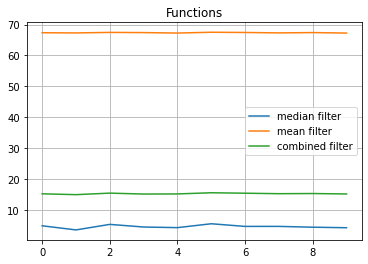

In [245]:
x = range(0,10)
plt.plot(x, b,label="median filter")
plt.plot(x, f,label="mean filter")
plt.plot(x, j,label="combined filter")
plt.legend()
plt.title('Functions')
plt.grid(True)
plt.show()

In [251]:
x=np.mean(b,0)
y=np.mean(f,0)
z=np.mean(j,0)
s=[x,y,z]
print(s)

[4.640178913998267, 67.37068834175733, 15.297673086897401]


In [233]:
def MSE(imageA ,imageB):
    sum = 0.0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            difference = abs(imageA[x,y] - imageB[x,y])
            sum = sum + difference*difference
    mse = sum /(imageA.shape[0]*imageA.shape[1])
    return mse 
def NRMSE(imageA,RMSE):
    sum = 0.0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            sum = sum + abs(imageA[x,y]*imageA[x,y])
    nrmse = sum /(imageA.shape[0]*imageA.shape[1])
    nrmse=np.sqrt(nrmse)
    return RMSE/nrmse 

def SNR(NRMSE):
    snr=[]
    for i in range (3):
        n=20*math.log10(NRMSE)
        snr.append(n)
    return snr

def PSNR(imageA,RMSE):
    max=0
    psnr=[]
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            if(abs(imageA[x,y])>max):
                max=abs(imageA[x,y])
        n=20*math.log10(max/RMSE)
        psnr.append(n)
    return psnr

In [207]:
def PSNR(imageA ,imageB,RMSE):
    sum = 0.0
    for x in range(imageA.shape[0]):
        for y in range(imageA.shape[1]):
            difference = (imageA[x,y] - imageB[x,y])
            sum = sum + difference*difference
    mse = sum /(imageA.shape[0]*imageA.shape[1])
    return mse 

In [118]:
def get_kernel(): # the declaration of the kernel for the mean filter.
    return np.array([[0.1, 0.1, 0.1], [0.1, 0.1, 0.1], [0.1, 0.1, 0.1]])

def mean_filter(image, height, width): #function of the mean filter.
    kernel = get_kernel()
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            # We get the area to be filtered with range indexing.
            area = image[row - 1:row + 2, column - 1:column + 2]
            image[row][column] = np.sum(np.multiply(kernel,area))
    return image

def median_filter(image, height, width): #function of the median filter.
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            area = image[row - 1:row + 2, column - 1:column + 2]
            image[row][column] = np.median(area)
    return image

def combined_filter(image, height, width): #function of the combined filter with the ratio for the median and mean filter.
    for row in range(1, height + 1):
        for column in range(1, width + 1):
            area = image[row - 1:row + 2, column - 1:column + 2]
            mean_filter = np.sum(np.multiply(get_kernel(),area))
            median_filter = np.median(area)
            image[row][column] = ratio * mean_filter + (1 - ratio) * median_filter
    return image

def filter_image(image,filtering_function):
    # We need the image size for the kernel looping.
    height, width = image.shape[:2]

    # We add 1px to allow kernels to work properly.
    image = cv.copyMakeBorder(image, 1, 1, 1, 1, cv.BORDER_REFLECT)
    res = filtering_function(image, height, width)
    return res